## II.3. Interlude: Basic transformations and adjustments

Before applying forecasting models, it is often necessary to preprocess the data through transformations and adjustments. The primary goals of these operations are to:
- **Stabilize the variance**, i.e., to make the distribution of the series more **normal-like**,
- account for **external factors** that are not part of the underlying pattern of the time series itself.

### II.3.A. Mathematical Transformations

Simple mathematical transformations can often linearize relationships and stabilize variance. 
A series with a **variance that grows over time** can be difficult to model. 
Applying a function like a **logarithm** or **square root** can often make the variance more constant, satisfying assumptions for many classical models.

-   **Logarithm (`log`)**: Particularly effective for series where the variance grows proportionally to the mean. It helps to stabilize the variance and linearize exponential growth trends.
-   **Square Root (`sqrt`), Cube Root (`cbrt`)**: Milder transformations than the logarithm, useful for reducing right-skewness and stabilizing variance.
-   **Inverse (`1/y`)**: A strong transformation, not as commonly used in forecasting but can be useful in specific contexts.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_series

from sktime.datasets import load_airline

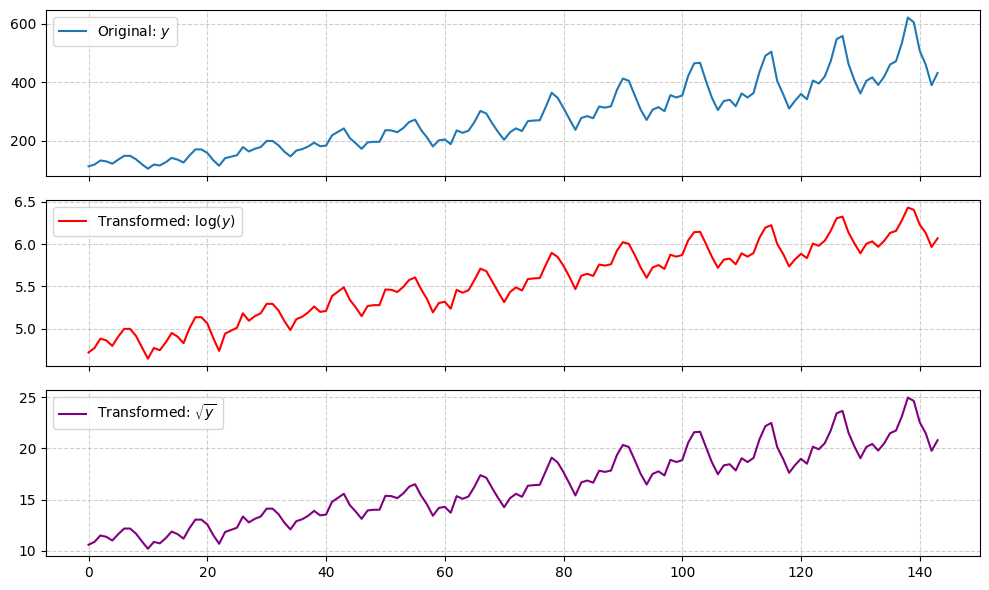

In [2]:
y = load_airline()

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for ax, y_ts, opts in zip(
    axes,
    [y, np.log(y), np.sqrt(y)],
    [
        {"label": r'Original: $y$'}, 
        {"label": r'Transformed: $\log(y)$', "color": "red"}, 
        {"label": r'Transformed: $\sqrt{y}$', "color": "purple"},
    ],
):
    ax.plot(y_ts.values, **opts)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#### Box-Cox transformation

The Box-Cox transformation is a **more powerful** and **generalized** power transformation that automatically finds an optimal parameter, $\lambda$ (lambda), to transform a series. Its goal is to find the best transformation to make the data more closely resemble a normal distribution and to stabilize its variance.

The transformation is defined as:
$$
y^{(\lambda)} = 
\begin{cases}
\ln(y) & \text{if } \lambda = 0,\\
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0. 
\end{cases}
$$

We can implement our own transformer, and use it, as presented below:

In [3]:
from utils import MyBoxCoxTransformer

y = load_airline()

bc_transformer = MyBoxCoxTransformer()
y_transformed_optimal = bc_transformer.fit_transform(y)

print(f"\nOptimal Lambda found by scipy: {bc_transformer.alpha:.4f}\n")


Optimal Lambda found by scipy: 0.1480



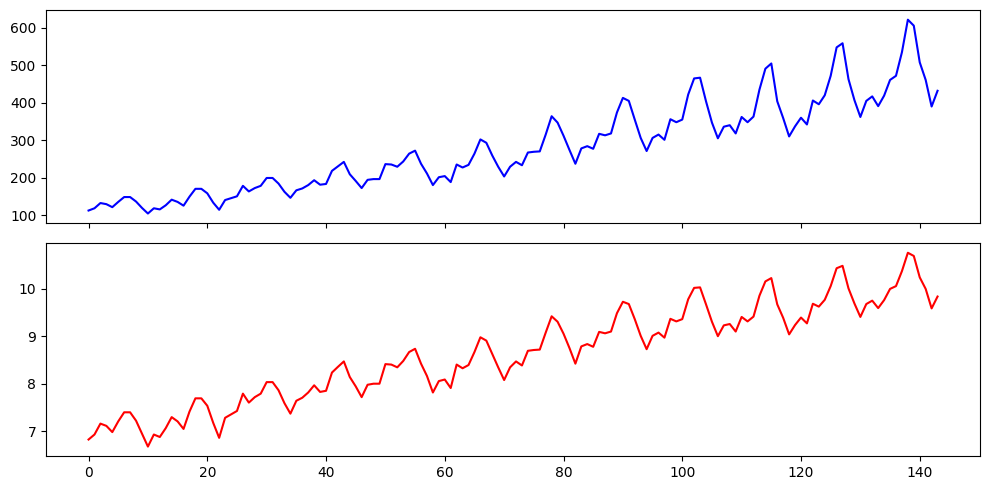

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

axes[0].plot(y.values, color="blue")
axes[1].plot(y_transformed_optimal, color="red")
fig.tight_layout()
plt.show()

#### Invert transform

One of the peculiarities of time-series transformations is that if we train a model using a transformed series, we will **need to invert the transformations** carried out, and that can be non-trivial. This is one of the reasons to introduce `sktime` transformers, as we will see in a bit.

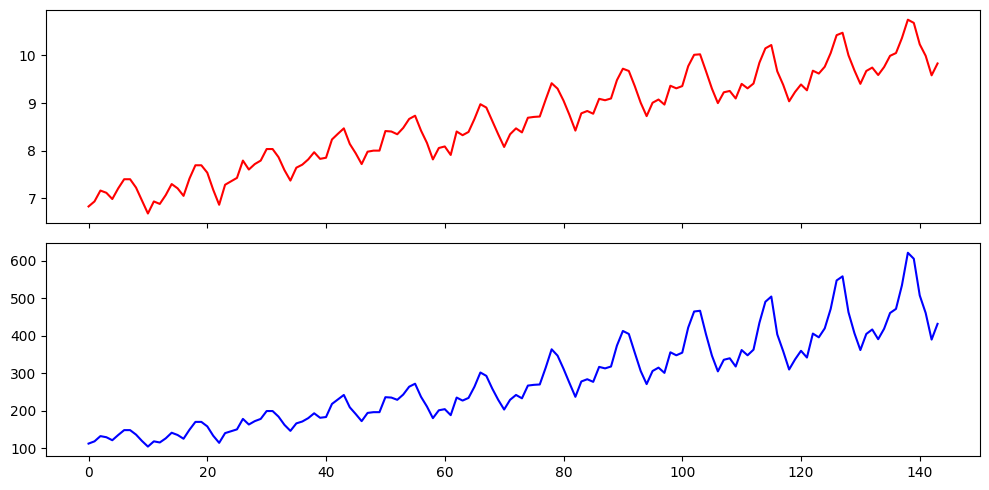

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axes[0].plot(y_transformed_optimal, color="red")
axes[1].plot(bc_transformer.inverse_transform(y_transformed_optimal), color="blue")
fig.tight_layout()
plt.show()

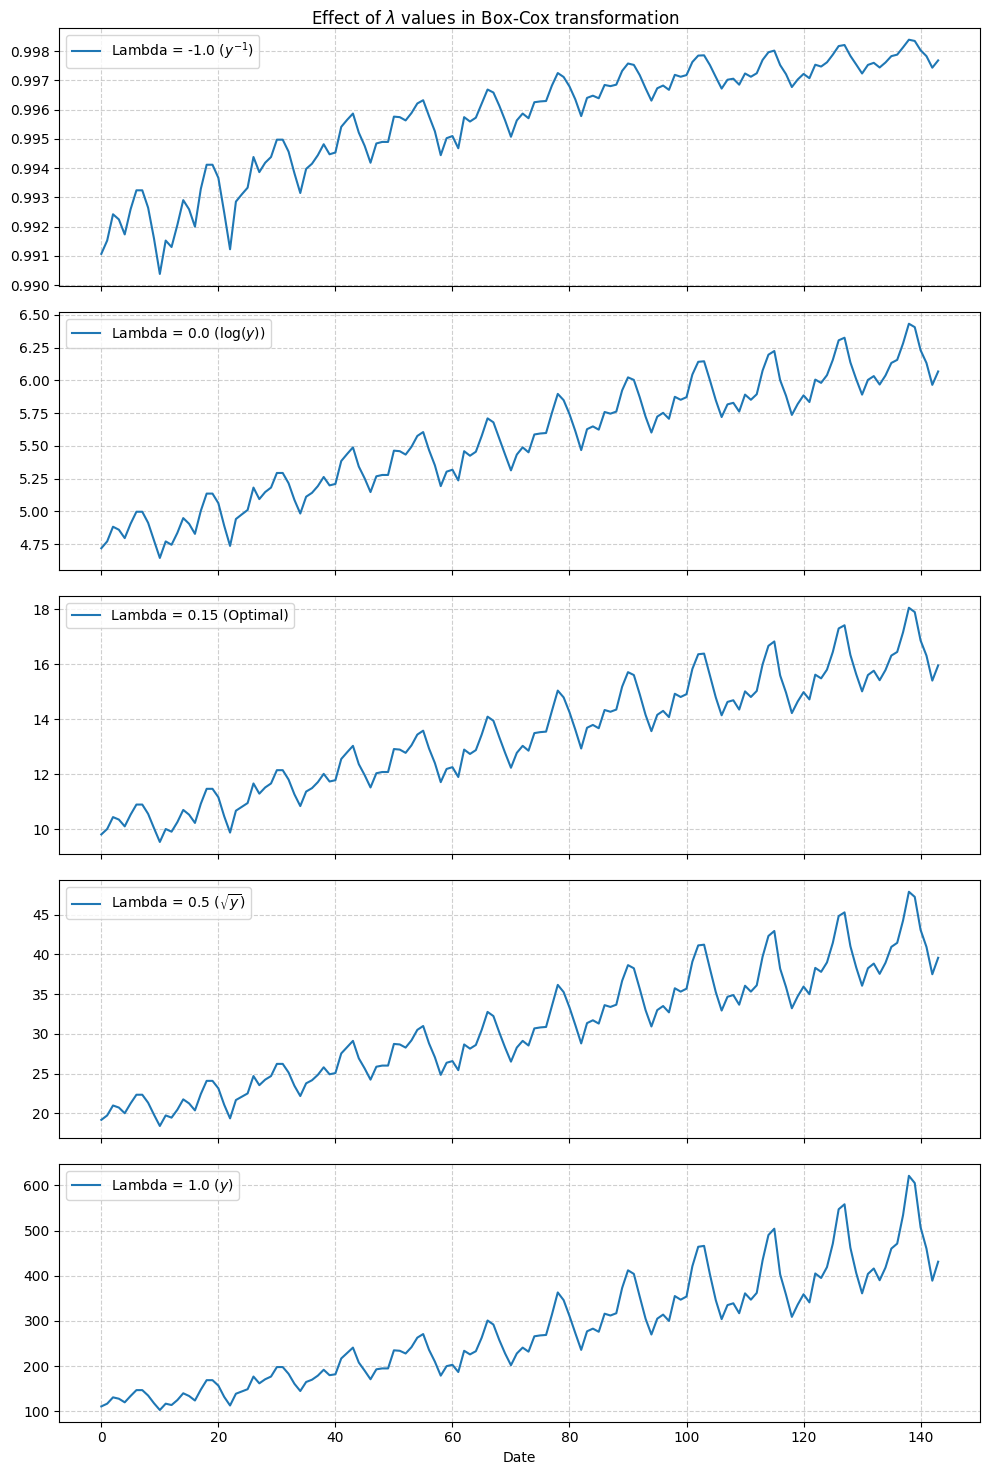

In [6]:
from matplotlib import pyplot as plt

lambda_values = [-1.0, 0.0, 0.28, 0.5, 1.0]
labels = [
    r'Lambda = -1.0 ($y ^{-1}$)',
    r'Lambda = 0.0 ($\log(y)$)',
    f'Lambda = {bc_transformer.alpha:.2f} (Optimal)',
    r'Lambda = 0.5 ($\sqrt{y}$)',
    r'Lambda = 1.0 ($y$)'
]

fig, axes = plt.subplots(len(lambda_values), 1, figsize=(10, 15), sharex=True)
fig.suptitle(r'Effect of $\lambda$ values in Box-Cox transformation', fontsize=12)

for i, value in enumerate(lambda_values):
    y_transformed = MyBoxCoxTransformer(alpha=value).transform(y)
    axes[i].plot(y_transformed, label=labels[i])
    axes[i].legend(loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

#### Time series transformers with `sktime`

We can use pre-built transformers which are already tested in the same way we do with `sklearn` transformers.
**Scikit Time** (or `sktime`) comes with a [bunch of transformers](https://www.sktime.net/en/stable/examples/03_transformers.html) (built-in and tested thoroughly!) so that we do not have to code them by ourselves. Also with the convenience that they will be very easily integrated in forecasting pipelines, as we will see later. Example:

In [7]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

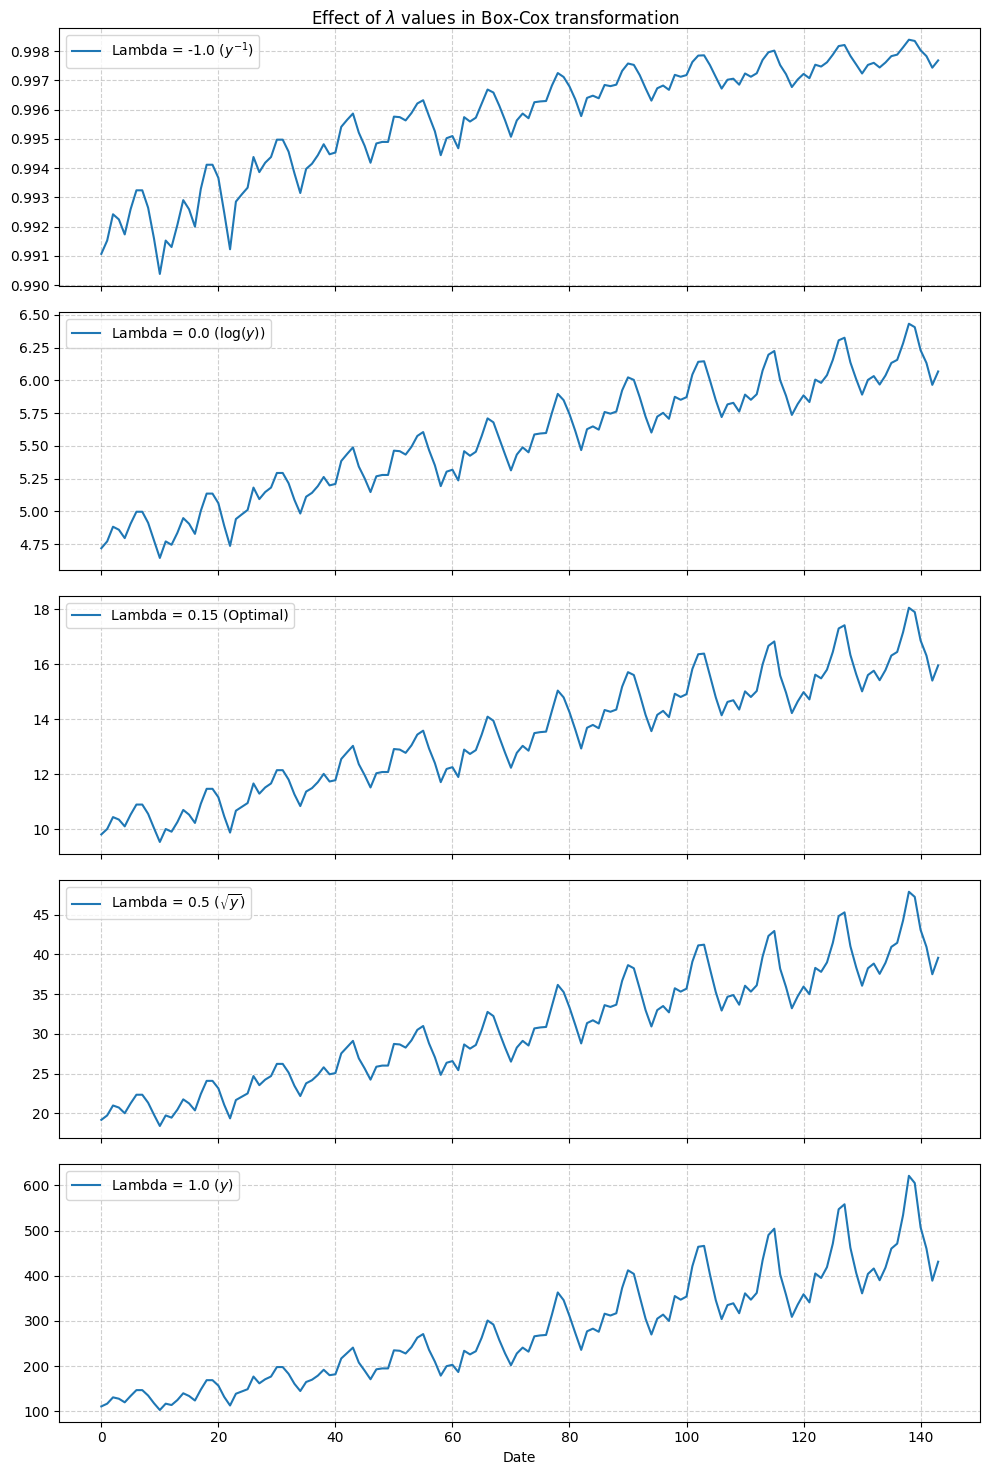

In [8]:
fig, axes = plt.subplots(len(lambda_values), 1, figsize=(10, 15), sharex=True)
fig.suptitle(r'Effect of $\lambda$ values in Box-Cox transformation', fontsize=12)

for i, l in enumerate(lambda_values):
    transformer = BoxCoxTransformer(method="fixed",  lambda_fixed=l)
    y_transformed = transformer.fit_transform(y)
    axes[i].plot(y_transformed.values, label=labels[i])
    axes[i].legend(loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

### II.3.B. Calendar Adjustments

Sometimes, variations in a time series are due to systemic, calendar, or economic effects rather than the underlying pattern of interest. Adjusting for these can lead to better forecasts.

Data aggregated over months can be misleading because months have different numbers of days (from 28 to 31). This can introduce artificial variation. This effect can be corrected by adjusting the data to represent an average month's length.

#### Example: Adjusting monthly electricity consumption - scale the consumption by the number of days in month

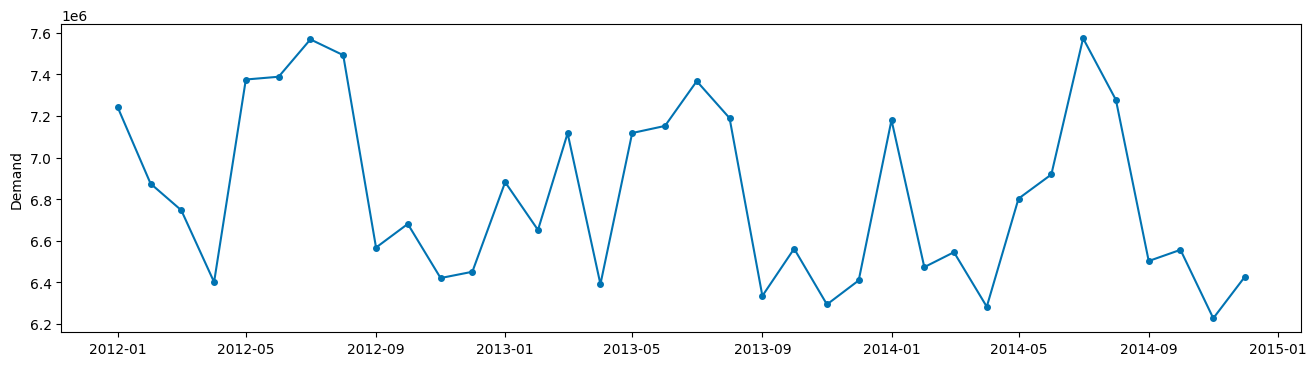

In [9]:
import pandas as pd
from utils import ExampleDataLoader

monthly_demand = ExampleDataLoader("monthly_demand").load()
monthly_demand.set_index(["Date"], inplace=True)

fig, ax = plot_series(monthly_demand["Demand"])

##### Manual adjustment (prone to future errors)

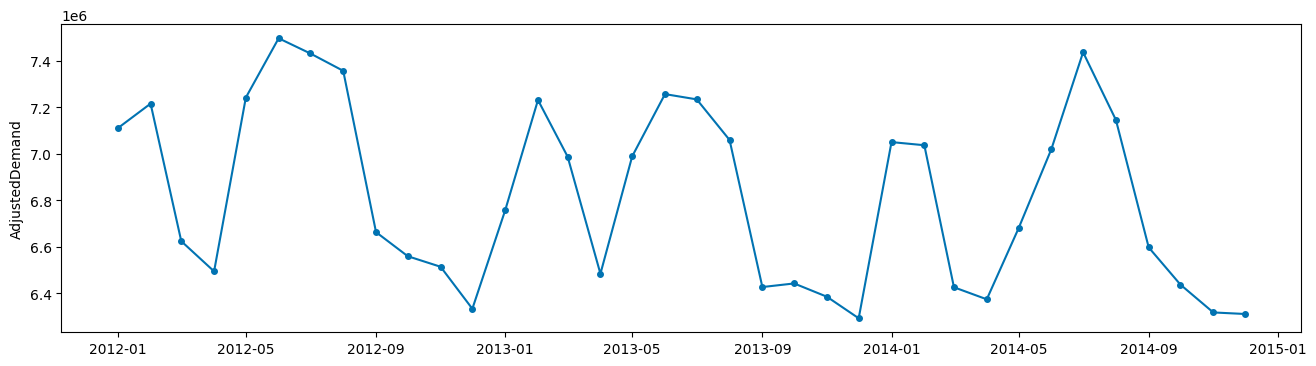

In [10]:
monthly_demand.reset_index(names=["Date"], inplace=True)

monthly_demand["DaysInMonth"] = monthly_demand["Date"].dt.days_in_month
avg_days_per_month = 365.25 / 12
monthly_demand["AdjustedDemand"] = (monthly_demand["Demand"] / monthly_demand["DaysInMonth"]) * avg_days_per_month

monthly_demand.set_index(["Date"], inplace=True)
fig, ax = plot_series(monthly_demand["AdjustedDemand"])

##### Using custom Time Series transfomers

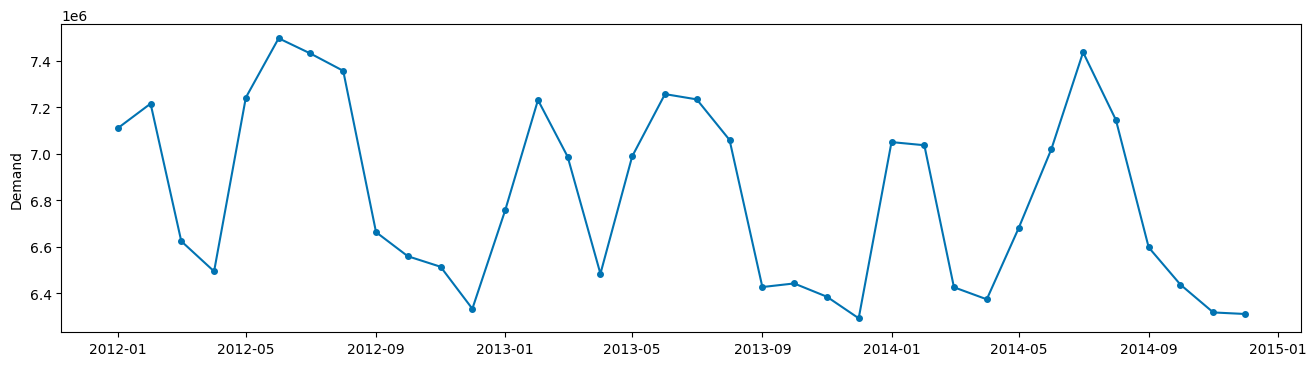

In [11]:
from utils import MyMonthlyAdjuster

monthly_demand = ExampleDataLoader("monthly_demand").load()
monthly_demand.set_index(["Date"], inplace=True)

fig, ax = plot_series(MyMonthlyAdjuster().fit_transform(monthly_demand))

### II.3.C. Economic Adjustments

Some useful adjustments needed when dealing with economic data are (amongst many others):

#### Inflation

When forecasting series involving monetary values (e.g., prices, revenue), it is crucial to account for inflation. This is done by deflating the series with a price index (like the Consumer Price Index, CPI) to get values in "real" or "constant" terms.

$$\text{real\_value} = (\text{nominal\_value} / \text{price\_index}) * 100$$

#### Population Growth

For series influenced by population size (e.g., number of public transport users, total sales of a product), it is often better to forecast a **per-capita** value. This removes the variation simply caused by a changing population.

  
$$\text{per\_capita\_value} = \text{total\_value} / \text{population}$$

Beyond inflation and population, several other external factors can distort the underlying patterns in economic data. Adjusting for these effects is a crucial step in building accurate and interpretable models.

#### Trading day and working day adjustment

* **Concept**: Months and quarters have a varying number of trading days or working days. For example, February has fewer working days than March, and a given quarter might have more weekends than another. This can cause significant variation in production or sales data that has nothing to do with economic health.

* **Example Series**: `Industrial Production`, `Exports/Imports`, `Monthly Retail Sales`.

* **Method of Adjustment**:
    * **Direct Scaling**: Divide the monthly total by the number of trading days in that month to get a "per-day" rate. This can then be multiplied by an average number of trading days per month to create an adjusted series.
    * **Regression Approach**: Use the number of trading days as an explanatory variable in a regression model (like ARIMA with regressors, known as REGARIMA). The model will estimate the effect of an additional trading day and effectively account for it.

#### Holiday effects

* **Concept**: While fixed holidays like Christmas contribute to standard seasonality, **moving holidays** like Easter can create major analytical challenges. Easter can fall in either March (Q1) or April (Q2), shifting a significant amount of economic activity (e.g., retail sales, travel) between quarters from one year to the next.
  
* **Example Series**: `Retail Sales` (especially for candy, clothing), `Tourist Arrivals`, `Air Passenger Traffic`.

  
* **Method of Adjustment**:
    * **Dummy/Indicator Variables**: Create a dummy variable that is `1` for the period affected by the moving holiday (e.g., the 7 days leading up to Easter) and `0` otherwise. This variable can then be included as a regressor in the model to capture the holiday's specific impact.

#### Exchange rate adjustment

* **Concept**: For any data involving international transactions, fluctuations in currency exchange rates can obscure underlying business performance. A company's revenue from foreign sales might increase in its home currency simply because the foreign currency strengthened, even if sales volume was flat.

* **Example Series**: `Export/Import Values`, `Revenue of a Multinational Corporation`, `Foreign Direct Investment (FDI)`.

* **Method of Adjustment**:
    * **Constant Exchange Rate**: Convert all foreign currency amounts to a single home currency using a constant exchange rate, typically the average rate from a fixed base year. This removes the effect of currency volatility.
    * **Analyze in Local Currency**: Analyze performance within a country or region in its own local currency before aggregating results.



#### Seasonal adjustment

* **Concept**: This is a fundamental and widespread adjustment in economics. It goes beyond just modeling seasonality and involves removing the seasonal component entirely to better highlight the underlying trend-cycle of the series. Most major government economic statistics (like GDP or unemployment) are presented in a seasonally adjusted (SA) form.
    
* **Example Series**: `Gross Domestic Product (GDP)`, `Unemployment Rate`, `Housing Starts`.
    
* **Method of Adjustment**:
    * **Standardized Programs**: Use well-established statistical programs like **X-13-ARIMA-SEATS** (developed by the U.S. Census Bureau) or methods like **STL Decomposition**. These are sophisticated methods that can handle various types of seasonality and calendar effects simultaneously.
    * `sktime` and other libraries provide interfaces to some of these methods (e.g., via `statsmodels`).

#### Adjustment for policy changes and structural breaks

* **Concept**: Economic series can change fundamentally due to external events that alter the "rules of the game." This is known as a structural break. Examples include a new tax law, a change in interest rate policy, a new trade agreement, or deregulation.

* **Example Series**: `Tax Revenue` before and after a tax cut, `Trade Volume` with a country after a new tariff is imposed, `Loan Applications` after a central bank policy change.

* **Method of Adjustment**:
    * **Intervention Analysis**: Use dummy variables to model the effect. A **step dummy** (0 before the event, 1 after) can model a permanent level shift. A **pulse dummy** (1 only at the time of the event, 0 otherwise) can model a temporary shock.
    * **Segmented Modeling**: Split the time series into two or more segments (before and after the break) and model each segment separately.